In [8]:
# Import core packages
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from xgboost import XGBClassifier
from sklearn.metrics import (
    classification_report, roc_auc_score, confusion_matrix,
    ConfusionMatrixDisplay, RocCurveDisplay, accuracy_score,
    precision_score, recall_score, f1_score
)
from imblearn.over_sampling import SMOTE
from imblearn.pipeline import Pipeline as ImbPipeline
from fairlearn.metrics import (
    MetricFrame, selection_rate, true_positive_rate, false_positive_rate
)
import shap
import joblib
import warnings
warnings.filterwarnings("ignore")


In [9]:
# Load processed data
X_train = pd.read_csv("../data/X_train_processed.csv")
X_test = pd.read_csv("../data/X_test_processed.csv")
y_train = pd.read_csv("../data/y_train_processed.csv").squeeze()
y_test = pd.read_csv("../data/y_test_processed.csv").squeeze()

In [10]:
print("Train size:", X_train.shape, "| Test size:", X_test.shape)
print("Class counts:\n", y_train.value_counts(normalize=True) * 100)

Train size: (46873, 39) | Test size: (11719, 39)
Class counts:
 claim_status
0    93.603994
1     6.396006
Name: proportion, dtype: float64


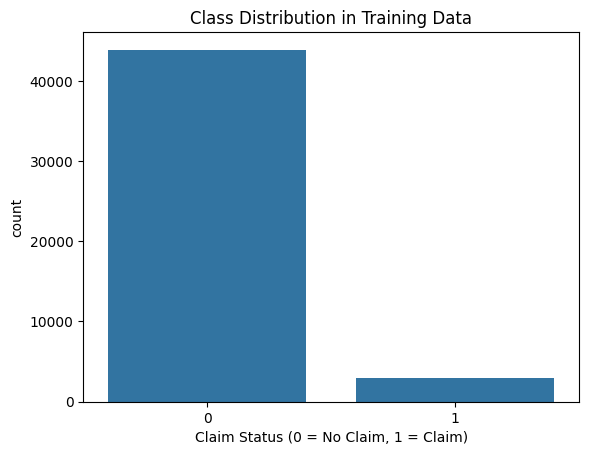

In [11]:
#Vizalization of class distribution in training data
sns.countplot(x=y_train)
plt.title("Class Distribution in Training Data")
plt.xlabel("Claim Status (0 = No Claim, 1 = Claim)")
plt.show()


In [12]:
#Define Preprocessing Pipelines
num_cols = X_train.select_dtypes(include=["int64","float64"]).columns.tolist()
cat_cols = X_train.select_dtypes(include=["object","category","bool"]).columns.tolist()

num_pipe = Pipeline([
    ("impute", SimpleImputer(strategy="median")),
    ("scale", StandardScaler())
])

cat_pipe = Pipeline([
    ("impute", SimpleImputer(strategy="most_frequent")),
    ("ohe", OneHotEncoder(handle_unknown="ignore", sparse_output=False))
])

preprocessor = ColumnTransformer([
    ("num", num_pipe, num_cols),
    ("cat", cat_pipe, cat_cols)
])


Training of Unbalanced Set (Base) to establish a baseline comparison (simple vs complex model), Observe how class imbalance affects linear vs non-linear algorithms.

In [13]:
#Logistic Regression (Base)
log_base = Pipeline([
    ("pre", preprocessor),
    ("clf", LogisticRegression(max_iter=1000, random_state=42))
])

log_base.fit(X_train, y_train)
y_pred_log = log_base.predict(X_test)
y_proba_log = log_base.predict_proba(X_test)[:,1]

print("=== Logistic Regression (Unbalanced) ===")
print(classification_report(y_test, y_pred_log))
print("ROC-AUC:", roc_auc_score(y_test, y_proba_log))


=== Logistic Regression (Unbalanced) ===
              precision    recall  f1-score   support

           0       0.94      1.00      0.97     10969
           1       0.00      0.00      0.00       750

    accuracy                           0.94     11719
   macro avg       0.47      0.50      0.48     11719
weighted avg       0.88      0.94      0.91     11719

ROC-AUC: 0.624998207068405


In [14]:
#Random Forest (Base)
rf_base = Pipeline([
    ("pre", preprocessor),
    ("clf", RandomForestClassifier(n_estimators=200, random_state=42))
])

rf_base.fit(X_train, y_train)
y_pred_rf = rf_base.predict(X_test)
y_proba_rf = rf_base.predict_proba(X_test)[:,1]

print("=== Random Forest (Unbalanced) ===")
print(classification_report(y_test, y_pred_rf))
print("ROC-AUC:", roc_auc_score(y_test, y_proba_rf))


=== Random Forest (Unbalanced) ===
              precision    recall  f1-score   support

           0       0.94      0.99      0.96     10969
           1       0.13      0.02      0.04       750

    accuracy                           0.93     11719
   macro avg       0.53      0.51      0.50     11719
weighted avg       0.89      0.93      0.90     11719

ROC-AUC: 0.5753084146230286


In [15]:
#Handle Class Imbalance with SMOTE
smote = SMOTE(random_state=42)

log_balanced = ImbPipeline([
    ("pre", preprocessor),
    ("smote", smote),
    ("clf", LogisticRegression(max_iter=1000, random_state=42))
])

rf_balanced = ImbPipeline([
    ("pre", preprocessor),
    ("smote", smote),
    ("clf", RandomForestClassifier(n_estimators=200, random_state=42))
])

# Fit models
log_balanced.fit(X_train, y_train)
rf_balanced.fit(X_train, y_train)

# Predictions
y_pred_log_bal = log_balanced.predict(X_test)
y_proba_log_bal = log_balanced.predict_proba(X_test)[:,1]

y_pred_rf_bal = rf_balanced.predict(X_test)
y_proba_rf_bal = rf_balanced.predict_proba(X_test)[:,1]

print("=== Logistic Regression (Balanced) ===")
print(classification_report(y_test, y_pred_log_bal))
print("ROC-AUC:", roc_auc_score(y_test, y_proba_log_bal))

print("\n=== Random Forest (Balanced) ===")
print(classification_report(y_test, y_pred_rf_bal))
print("ROC-AUC:", roc_auc_score(y_test, y_proba_rf_bal))


=== Logistic Regression (Balanced) ===
              precision    recall  f1-score   support

           0       0.96      0.58      0.72     10969
           1       0.09      0.61      0.16       750

    accuracy                           0.58     11719
   macro avg       0.52      0.60      0.44     11719
weighted avg       0.90      0.58      0.68     11719

ROC-AUC: 0.6218274531254748

=== Random Forest (Balanced) ===
              precision    recall  f1-score   support

           0       0.94      0.94      0.94     10969
           1       0.09      0.09      0.09       750

    accuracy                           0.88     11719
   macro avg       0.51      0.51      0.51     11719
weighted avg       0.88      0.88      0.88     11719

ROC-AUC: 0.591105782964111


In [20]:
from scipy import stats
from imblearn.combine import SMOTETomek
from imblearn.pipeline import Pipeline as ImbPipeline
from joblib import dump
from sklearn.model_selection import RandomizedSearchCV

smt = SMOTETomek(random_state=42)


# Logistic Regression (Fast + Balanced)

from imblearn.pipeline import Pipeline as ImbPipeline

log_best = ImbPipeline([
    ("pre", preprocessor),
    ("smt", smt),
    ("clf", LogisticRegression(
        C=1, 
        class_weight='balanced',
        max_iter=1000,
        random_state=42
    ))
])

print("🔹 Training Logistic Regression (Balanced)")
log_best.fit(X_train, y_train)

# Predictions
y_pred_log_best = log_best.predict(X_test)
y_proba_log_best = log_best.predict_proba(X_test)[:, 1]

print("\n=== Logistic Regression (Balanced + Optimized) ===")
print(classification_report(y_test, y_pred_log_best))
print("ROC-AUC:", roc_auc_score(y_test, y_proba_log_best))

from xgboost import XGBClassifier
from imblearn.pipeline import Pipeline as ImbPipeline
from imblearn.combine import SMOTETomek
from sklearn.metrics import classification_report, roc_auc_score

# Reuse preprocessor and SMOTETomek
smt = SMOTETomek(random_state=42)

# Compute imbalance ratio for XGBoost weight
scale_pos_weight = y_train.value_counts()[0] / y_train.value_counts()[1]

# XGBoost Pipeline
xgb_pipe = ImbPipeline([
    ("pre", preprocessor),
    ("smt", smt),
    ("clf", XGBClassifier(
        n_estimators=400,
        learning_rate=0.05,
        max_depth=6,
        subsample=0.8,
        colsample_bytree=0.8,
        random_state=42,
        scale_pos_weight=scale_pos_weight,
        eval_metric="auc",
        use_label_encoder=False,
        n_jobs=-1
    ))
])

print("\n🔹 Training XGBoost (Balanced + Tuned)")
xgb_pipe.fit(X_train, y_train)

# Predictions
y_pred_xgb = xgb_pipe.predict(X_test)
y_proba_xgb = xgb_pipe.predict_proba(X_test)[:, 1]

print("\n=== XGBoost (Balanced + Tuned) ===")
print(classification_report(y_test, y_pred_xgb))
print("ROC-AUC:", roc_auc_score(y_test, y_proba_xgb))

# Save best model
from joblib import dump
import os
# Ensure the 'artifacts' folder exists
os.makedirs("artifacts", exist_ok=True)
dump(xgb_pipe, "artifacts/xgb_balanced_tuned.joblib")

print("\n✅ XGBoost model trained and saved successfully.")


🔹 Training Logistic Regression (Balanced)

=== Logistic Regression (Balanced + Optimized) ===
              precision    recall  f1-score   support

           0       0.96      0.58      0.72     10969
           1       0.09      0.61      0.16       750

    accuracy                           0.58     11719
   macro avg       0.52      0.59      0.44     11719
weighted avg       0.90      0.58      0.68     11719

ROC-AUC: 0.6218875011395751

🔹 Training XGBoost (Balanced + Tuned)

=== XGBoost (Balanced + Tuned) ===
              precision    recall  f1-score   support

           0       0.97      0.41      0.57     10969
           1       0.08      0.79      0.15       750

    accuracy                           0.43     11719
   macro avg       0.52      0.60      0.36     11719
weighted avg       0.91      0.43      0.55     11719

ROC-AUC: 0.6339142431701462

✅ XGBoost model trained and saved successfully.


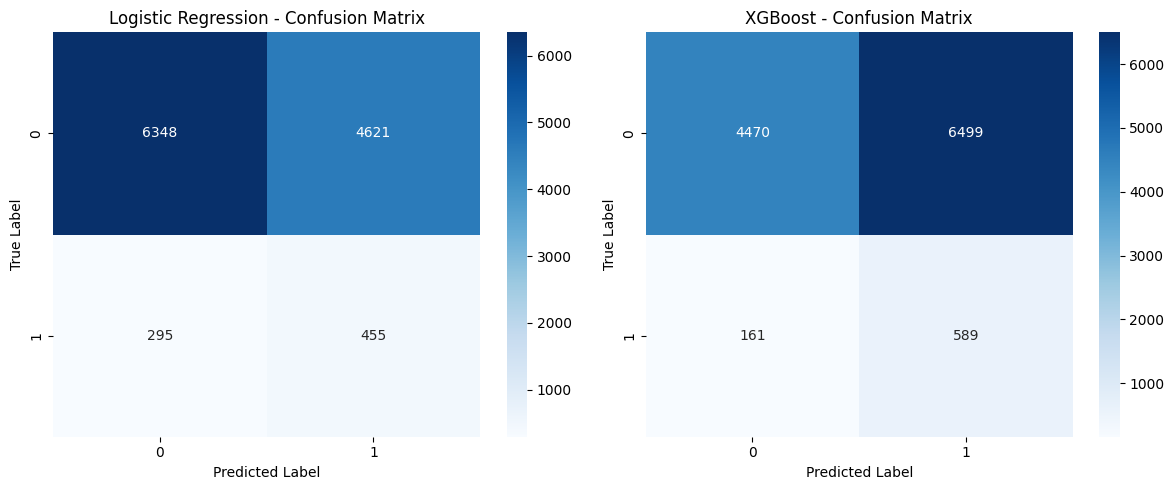

In [21]:
#Confusion Matrices for All Models
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix

# Confusion matrices
models = {
    "Logistic Regression": (y_test, y_pred_log_best),
    "XGBoost": (y_test, y_pred_xgb)
}

fig, axes = plt.subplots(1, 2, figsize=(12, 5))
for ax, (name, (y_true, y_pred)) in zip(axes, models.items()):
    cm = confusion_matrix(y_true, y_pred)
    sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", ax=ax)
    ax.set_title(f"{name} - Confusion Matrix")
    ax.set_xlabel("Predicted Label")
    ax.set_ylabel("True Label")
plt.tight_layout()
plt.show()


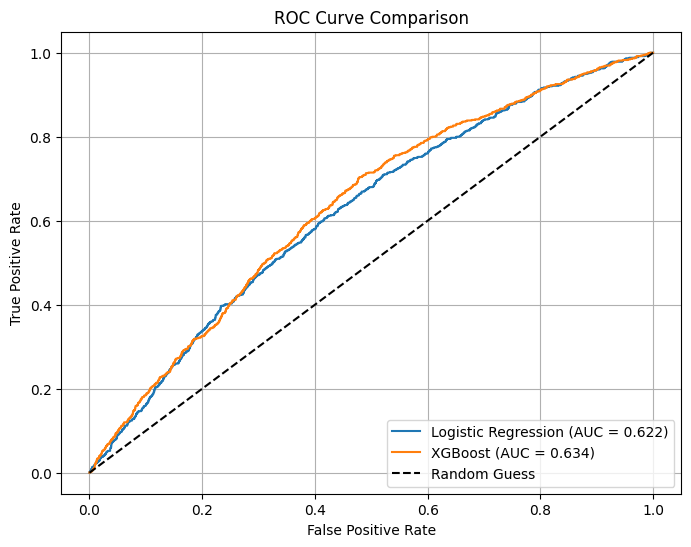

In [22]:
#ROC Curves (Comparing Model Quality)
from sklearn.metrics import roc_curve, auc

plt.figure(figsize=(8,6))

# Logistic Regression
fpr_log, tpr_log, _ = roc_curve(y_test, y_proba_log_best)
roc_auc_log = auc(fpr_log, tpr_log)
plt.plot(fpr_log, tpr_log, label=f"Logistic Regression (AUC = {roc_auc_log:.3f})")

# XGBoost
fpr_xgb, tpr_xgb, _ = roc_curve(y_test, y_proba_xgb)
roc_auc_xgb = auc(fpr_xgb, tpr_xgb)
plt.plot(fpr_xgb, tpr_xgb, label=f"XGBoost (AUC = {roc_auc_xgb:.3f})")

# Reference line
plt.plot([0, 1], [0, 1], "k--", label="Random Guess")

plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve Comparison")
plt.legend(loc="lower right")
plt.grid(True)
plt.show()



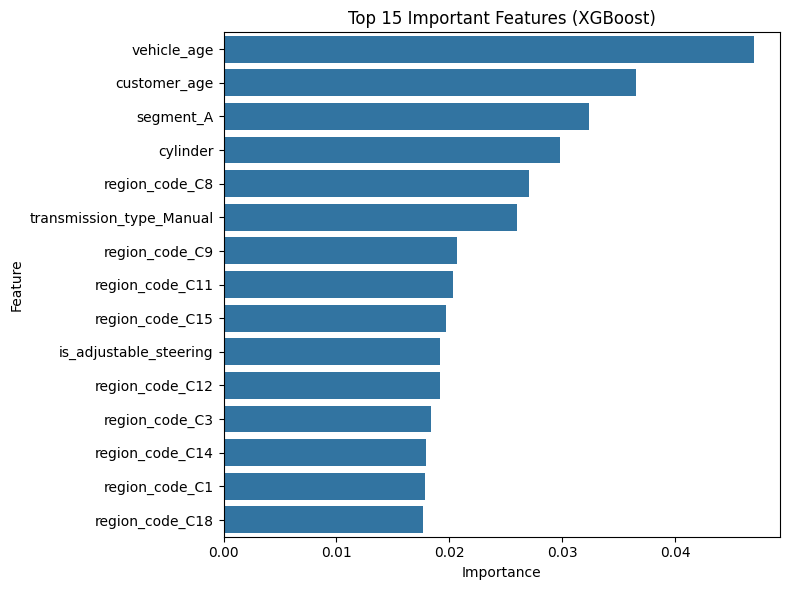

In [23]:
#Feature Importance from XGBoost
import pandas as pd
import numpy as np

# Extract feature names from preprocessor
num_features = preprocessor.named_transformers_["num"].get_feature_names_out()
cat_features = preprocessor.named_transformers_["cat"].get_feature_names_out()
feature_names = np.concatenate([num_features, cat_features])

# Get feature importances
xgb_model = xgb_pipe.named_steps["clf"]
importances = xgb_model.feature_importances_

feat_imp = pd.DataFrame({
    "Feature": feature_names,
    "Importance": importances
}).sort_values("Importance", ascending=False)

# Plot top 15
plt.figure(figsize=(8,6))
sns.barplot(x="Importance", y="Feature", data=feat_imp.head(15))
plt.title("Top 15 Important Features (XGBoost)")
plt.tight_layout()
plt.show()
